# imports & settings

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%precision %.3f

from glob import glob
from tqdm import tqdm

from os.path import join
import ntpath 
from copy import deepcopy
import pytz
TZ = pytz.FixedOffset(540) # GMT+09:00; Asia/Seoulsilent


%load_ext autoreload
%autoreload 2
import sys  
sys.path.insert(0, '../') # to import from parent directory
import utils
from utils import *
import recept_dataset
from f_preprocessing import impute_support_features, impute, normalize

from sklearn import metrics 
from sklearn.model_selection import StratifiedKFold, GroupKFold

import warnings
from functools import reduce
from itertools import product

import matplotlib
matplotlib.rc('font', size=22)
from matplotlib import pyplot as plt

In [3]:
RANDOM_STATE=utils.RANDOM_STATE
DATAROOT = utils.DATAROOT
BALANCED_TRAINING = False
ALREADY_EXTRACTED_SUBFEATURES = True

## Function definitions for classification experiment

### metrics

In [4]:
def perf_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    y_pred_cls = np.rint(y_pred)    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        acc = metrics.accuracy_score(y_true, y_pred_cls)
        acc_bal = metrics.balanced_accuracy_score(y_true, y_pred_cls)
        f1_score = metrics.f1_score(
            y_true=y_true, y_pred=y_pred_cls,average='macro',pos_label=1
        )
        auc = metrics.roc_auc_score(
            y_true=y_true, y_score=y_pred, average='macro'
        )
    return dict(
        ACC=acc*100, ACC_BAL=acc_bal*100, F1_score = f1_score*100
        , AUC=auc
    )


### classifiers

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
import catboost

classifiers = {
    'lr':LogisticRegression(random_state = RANDOM_STATE, max_iter=500 )
    ,'knn':KNeighborsClassifier(),
    'svm':SVC(probability=True),
    'gp':GaussianProcessClassifier(),
    'dt':DecisionTreeClassifier(random_state = RANDOM_STATE),
    'rf':RandomForestClassifier(random_state = RANDOM_STATE),
    'mlp':MLPClassifier(),
    'adaboost':AdaBoostClassifier(),
    'gnb':GaussianNB(),
    'qda':QuadraticDiscriminantAnalysis(),
    'catboost': catboost.CatBoostClassifier(
        random_seed=RANDOM_STATE, eval_metric='AUC'
    )    
    #,'xgboost':xgb.Booster()
    }



classifier_names = {
    'lr':'LogisticRegression'
    ,'knn':'KNeighborsClassifier',
    'svm':'SVM',
    'gp':'GaussianProcess',
    'dt':'DecisionTree',
    'rf':'RandomForest',
    'mlp':'Multi-layer Perceptron',
    'adaboost':'AdaBoost',
    'gnb':'Gaussian Naive Bayes',
    'qda':'QuadraticDiscriminantAnalysis',
    'catboost':'CatBoost'
    #,'xgboost':'XGBoost'
}

### run_classification

In [6]:
def run_classification(
    df, use_ray = True,  cat_features=None, classifier_name='catboost',
    feature_selection = None, experiment_name=''
) :   
    y = df['receptivity'].replace({
        'receptive':1,'non-receptive':0
    })
    X = df.drop(columns='receptivity')
    pids = df.index.get_level_values('pid')

    results = LOGO_5fold(
        X,y, pids, feature_selection=feature_selection,
        cat_features=cat_features,
        classifier_name=classifier_name
        ,use_ray=use_ray
    )
    
    results.insert(results.shape[1], 'experiment',experiment_name)
    return results
    


### CV

In [7]:
def LOGO_5fold(
    X,y, pids, cat_features=None, classifier_name='catboost',
    feature_selection = None
    , use_ray=False
):
    func = ray.remote(run_trial).remote if use_ray else run_trial
    results = []    
    for train_index, test_index in tqdm(
        GroupKFold(n_splits=5).split(X, y, groups=pids)
    ):        
        res = func(
            X,y, train_index,test_index,
            cat_features=cat_features, classifier_name=classifier_name,
            feature_selection = feature_selection
        )
        results.append(res) 
    results = ray.get(results) if use_ray else results
    results = pd.DataFrame(results)
    results.insert(results.shape[1],'CV_TYPE','LOGO_5fold')
    return results


### run trial

In [8]:
def run_trial(X, y,  train_index,test_index,             
              feature_selection = None, cat_features=None, 
              classifier_name='catboost'):

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    if BALANCED_TRAINING:
        X_train, y_train = balance_data(X_train, y_train)
        
    if feature_selection['status']:
        X_train = select_features(X_train, y_train, feature_selection)
        
    clf = classifiers[classifier_name]
    feature_names =X_train.columns.tolist()

    if classifier_name=='catboost':
        d_train = catboost.Pool(
            data = X_train,
            label = y_train,
            feature_names = feature_names,
            cat_features = cat_features
        )
        
        clf.fit(X = d_train, verbose_eval=False, early_stopping_rounds=20)
    else:
        clf.fit(X_train, y_train)
        
    prob = clf.predict_proba(X.iloc[test_index][feature_names])[:,1]
    test_metrics = perf_metrics(y.iloc[test_index], prob)    

    prob = clf.predict_proba(X.iloc[train_index][feature_names])[:,1]
    train_metrics = perf_metrics(y.iloc[train_index], prob)

    res = {f'TEST_{k}':v  for k,v in test_metrics.items()}
    res.update({f'TRAIN_{k}':v  for k,v in train_metrics.items()})
    return res    

### balance data

In [9]:
from imblearn.over_sampling import RandomOverSampler
def balance_data(X_train, y_train):
    ros = RandomOverSampler(random_state=RANDOM_STATE)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    return X_train, y_train
    

### feature selection

In [10]:
from sklearn.linear_model import  Lasso
def select_features(X_train, y_train, feature_selection):
    if feature_selection['method']=='LASSO':
        classifier = Lasso(tol=1e-3)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            classifier.fit(X=X_train, y=y_train)
        coef=np.abs(classifier.coef_)
        I = coef.argsort()
        keep_ratio=feature_selection['keep_ratio']
        num_features_to_keep = int(keep_ratio*X_train.shape[1])            

        X_train =  X_train[X_train.columns[I[-1*num_features_to_keep:]]]
        return X_train
        

# Data Split

In [11]:

LABEL_DTYPES = {
            'valence':float
            ,'arousal': float
            ,'attention': float
            ,'stress': float
            ,'duration': float
            ,'change': float
            , 'pid':str            
        }
labels = pd.read_csv(
    join(DATAROOT,'binned_esm_data.csv'), 
    dtype=LABEL_DTYPES,
    parse_dates=['timestamp']
).set_index(['pid','timestamp'])

pids = labels.index.get_level_values('pid').unique().tolist()
N = len(pids)
r = .5 # rule mining pariticpants ratio
arm_pids = pids[:int(N*r)]

labels_arm = labels[labels.index.get_level_values('pid').isin(arm_pids)]
labels_ml = labels[~labels.index.get_level_values('pid').isin(arm_pids)]
labels_arm.shape, labels_ml.shape
print("arm_pids",len(np.unique(arm_pids)),'ml_pids'
      , len(np.unique(pids))-len(np.unique(arm_pids)))

arm_pids 36 ml_pids 37


In [12]:
labels_arm.shape, labels_ml.shape

((1580, 20), (1754, 20))

# RuleGenerateSet


In [12]:
labels_arm.receptivity.value_counts()

receptive        913
non-receptive    667
Name: receptivity, dtype: int64

In [13]:
labels_ml.receptivity.value_counts()

receptive        1025
non-receptive     729
Name: receptivity, dtype: int64

In [14]:

num_participants = labels_arm.index.get_level_values('pid').nunique()


sub_winsize = 20 # min
print('number of sub-windows (transactions) for the given feature:\n num_participants*days_of_collection*collection_hours*MIN_IN_HOUR/sub_winsize')
num_participants*utils.COLLECTION_DAYS*utils.COLLECTION_HOURS*utils.MIN_IN_HOUR//sub_winsize

number of sub-windows (transactions) for the given feature:
 num_participants*days_of_collection*collection_hours*MIN_IN_HOUR/sub_winsize


9072

### window size selection
- which window size
    - 40  MIN
    - 80  MIN
    

- how many sub window size
    - 2
    - 4
    - 8

In [15]:
windows = [40,80,160]
num_sub_windows = [2,4,8]


#### Extract sub features

In [16]:
from itertools import product
import os.path as osp
with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=40):    
    for nsub, window_size_in_min in product(num_sub_windows,windows):
        fn = f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
        print(fn)
        if not osp.exists(fn):
            print(f'{fn} exists')
            sub_features = recept_dataset.parallellize_extract_sub(
                labels=labels_arm
                , w_size_in_min = window_size_in_min
                ,num_sub=nsub
            )
            sub_features.to_csv(
                f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv')

feature/arm/subfeature_40MIN_2.csv
feature/arm/subfeature_80MIN_2.csv
feature/arm/subfeature_160MIN_2.csv
feature/arm/subfeature_40MIN_4.csv
feature/arm/subfeature_80MIN_4.csv
feature/arm/subfeature_160MIN_4.csv
feature/arm/subfeature_40MIN_8.csv
feature/arm/subfeature_80MIN_8.csv
feature/arm/subfeature_160MIN_8.csv


#### select window size

##### find missing features per combination

In [17]:
measurement = pd.DataFrame( columns=[
    'number of subwindows'
    ,'window size'
    ,'ratio of missing features'
])

for nsub, window_size_in_min in product(num_sub_windows,windows):
    sub_features = pd.read_csv(
        f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
    ).set_index(['pid','timestamp','sub_timestamp']) 
    
    sub_features = impute_support_features(sub_features)
    ds = sub_features.isnull().sum(axis=0)  
    N,D = sub_features.shape
    ds = ds.sort_values(ascending=True)/(N*D)
    
    measurement = pd.concat(
        [
            measurement
            ,pd.DataFrame({
                'number of subwindows':[nsub]
                ,'window size':[window_size_in_min]
                ,'ratio of missing features':[ds.sum()*100]
            })
        ]
        , ignore_index=True
    )

pd.set_option("display.precision", 2)

measurement = measurement.set_index([
    'number of subwindows','window size'
]).sort_index()
measurement.to_csv(f'setting/missing_feature_for_each_combinations.csv')
measurement

ratio of missing features
number of subwindows window size                           
2                    40                               3.338
                     80                               3.177
                     160                              3.232
4                    40                               3.641
                     80                               3.584
                     160                              3.824
8                    40                               3.912
                     80                               3.884
                     160                              4.252

### aggregated features 


#### compute

In [18]:
EXTRACTED_AGGRAGETED = False

def read_sub_features(window_size_in_min=80, nsub=4):
    fn = f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
    sub_features = pd.read_csv(
        fn
        ,dtype={'pid':str}
        ,parse_dates=['timestamp','sub_timestamp']
    ).set_index(['pid','timestamp','sub_timestamp'])
    return sub_features


def extract_aggregated_features(window_size_in_min=80, nsub=4):
    sub_features = read_sub_features(window_size_in_min, nsub)
    sub_features_preprocessed = impute_support_features(
            normalize(sub_features)
    )

    agg_feature = sub_features_preprocessed.groupby(
        ['pid','timestamp']
    ).agg(['mean','std'])
    agg_feature.columns = agg_feature.columns.map('|'.join).str.strip('|')
    agg_feature.to_csv(
        f'feature/arm/agg_feature_{window_size_in_min}MIN_{nsub}.csv'
    )

In [19]:
import recept_dataset 
window_size_in_min, nsub = 80, 4 # selected above

if not EXTRACTED_AGGRAGETED:
    extract_aggregated_features()
    
agg_feature = pd.read_csv(
    f'feature/arm/agg_feature_{window_size_in_min}MIN_{nsub}.csv'
    ,dtype={'pid':str}
    ,parse_dates=['timestamp']
).set_index(['pid','timestamp'])
agg_feature

appUsage_appPackage#ETP|mean  \
pid  timestamp                                           
1501 2019-05-16 12:17:02                         0.117   
     2019-05-16 13:46:27                         0.205   
     2019-05-16 14:28:19                         0.153   
     2019-05-16 15:12:59                         0.222   
     2019-05-16 16:41:48                         0.342   
...                                                ...   
729  2019-05-14 18:10:13                         0.496   
     2019-05-14 18:54:15                         0.446   
     2019-05-14 19:33:13                         0.597   
     2019-05-14 20:16:19                         0.504   
     2019-05-14 21:02:23                         0.422   

                          appUsage_appPackage#ETP|std  \
pid  timestamp                                          
1501 2019-05-16 12:17:02                        0.195   
     2019-05-16 13:46:27                        0.220   
     2019-05-16 14:28:19                        0.257   
     2019-05-16 15:12:59                        0.272   
     2019-05-16 16:41:48                        0.208   
...                                               ...   
729  2019-05-14 18:10:13                        0.101   
     2019-05-14 18:54:15                        0.174   
     2019-05-14 19:33:13                        0.221   
     2019-05-14 20:16:19                        0.252   
     2019-05-14 21:02:23                        0.247   

                          appUsage_appPackage#ASC|mean  \
pid  timestamp                                           
1501 2019-05-16 12:17:02                         0.065   
     2019-05-16 13:46:27                         0.047   
     2019-05-16 14:28:19                         0.083   
     2019-05-16 15:12:59                         0.110   
     2019-05-16 16:41:48                         0.122   
...                                                ...   
729  2019-05-14 18:10:13                         0.169   
     2019-05-14 18:54:15                         0.160   
     2019-05-14 19:33:13                         0.151   
     2019-05-14 20:16:19                         0.200   
     2019-05-14 21:02:23                         0.234   

                          appUsage_appPackage#ASC|std  \
pid  timestamp                                          
1501 2019-05-16 12:17:02                        0.103   
     2019-05-16 13:46:27                        0.045   
     2019-05-16 14:28:19                        0.128   
     2019-05-16 15:12:59                        0.146   
     2019-05-16 16:41:48                        0.081   
...                                               ...   
729  2019-05-14 18:10:13                        0.078   
     2019-05-14 18:54:15                        0.109   
     2019-05-14 19:33:13                        0.102   
     2019-05-14 20:16:19                        0.059   
     2019-05-14 21:02:23                        0.155   

                          appUsage_appCategory#ETP|mean  \
pid  timestamp                                            
1501 2019-05-16 12:17:02                          0.130   
     2019-05-16 13:46:27                          0.123   
     2019-05-16 14:28:19                          0.169   
     2019-05-16 15:12:59                          0.229   
     2019-05-16 16:41:48                          0.356   
...                                                 ...   
729  2019-05-14 18:10:13                          0.541   
     2019-05-14 18:54:15                          0.474   
     2019-05-14 19:33:13                          0.552   
     2019-05-14 20:16:19                          0.508   
     2019-05-14 21:02:23                          0.492   

                          appUsage_appCategory#ETP|std  \
pid  timestamp                                           
1501 2019-05-16 12:17:02                         0.214   
     2019-05-16 13:46:27                         0.180   
     2019-05-16 14:28:19        

In [20]:
agg_feature.isnull().sum(axis=0).sort_values(ascending=False)

unlock#ASC|std                               1580
unlock#ETP|std                               1580
headsetEvent#ASC|std                         1580
headsetEvent#ASC|mean                        1580
unlock#ASC|mean                              1580
                                             ... 
appUsage_appCategory#SUP:Lifestyle|mean         0
appUsage_appCategory#SUP:Photography|std        0
appUsage_appCategory#SUP:Photography|mean       0
connection_status#SUP:True|std                  0
battery_plugState#SUP:WIRELESS|std              0
Length: 778, dtype: int64

#### Feature selection

##### missing count thresholding
- discard if the feature is missing more than 20% of the time

24/778 removed


Text(0, 0.5, 'Percentage of missing cases')

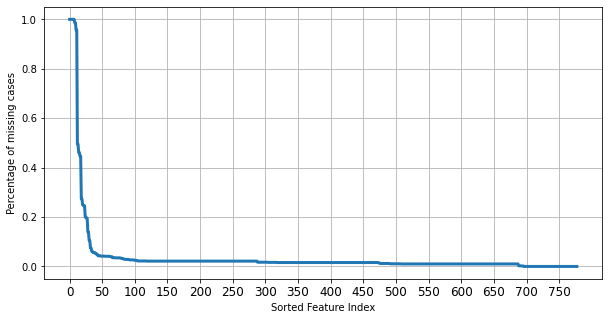

In [21]:
missing_ratio = agg_feature.isnull().sum(axis=0)/len(agg_feature)

agg_feature_percent_missing  = agg_feature.loc[:,(missing_ratio[missing_ratio<.2]).index]
print(f"{agg_feature.shape[1]-agg_feature_percent_missing.shape[1]}/{agg_feature.shape[1]} removed")

# visuzlize missing ratio
plt.figure(figsize=(10,5))
N, D = agg_feature.shape
missing_ratio.sort_values(ascending=False).plot(linewidth=3)
I = np.arange(0,D,50)
plt.xticks(I,I, fontsize=12);
plt.grid()
plt.xlabel('Sorted Feature Index')
plt.ylabel('Percentage of missing cases')


##### Pairwise Correlation

###### prepare features order
- features highly correlated with target variable should come first in corr matrix


In [22]:
corr_with_outcome = pd.merge(
    labels_arm[['disturbance']],
    agg_feature_percent_missing
    ,left_index=True, right_index=True
).corr()['disturbance'].abs().sort_values(ascending=False)
corr_with_outcome

disturbance                                  1.000
ringer#SUP:RINGER_MODE_NORMAL|mean           0.256
data_RX2TX#MAX|std                           0.192
battery_plugState#SUP:WIRELESS|std           0.177
battery_plugState#SUP:WIRELESS|mean          0.170
                                              ... 
bandUV_indexLevel#SUP:MEDIUM|std             0.000
bandAmbientLight_brightness#MINLAGVAL|mean   0.000
bandHeartRate_BPM#MINLAG|std                 0.000
location_distance#BEP|mean                   0.000
accelerometer_Z#SKW|std                      0.000
Name: disturbance, Length: 755, dtype: float64

In [23]:
importance_order = corr_with_outcome.index.to_list()[1:] # remove `disturbance`
Matrix = agg_feature_percent_missing[importance_order].corr()

Matrix

,ringer#SUP:RINGER_MODE_NORMAL|mean,data_RX2TX#MAX|std,battery_plugState#SUP:WIRELESS|std,battery_plugState#SUP:WIRELESS|mean,data_RX2TX#VAR|std,data_RX2TX#MAX|mean,data_RX2TX#VAR|mean,appUsage_appPackage#ETP|mean,screen#ASC|mean,appUsage_appPackage#ASC|mean,...,data_TX#SKW|std,bandDistance_pace#MIN|mean,accelerometer_Y#MIN|std,location_cluster#ETP|std,bandUV_indexLevel#SUP:MEDIUM|mean,bandUV_indexLevel#SUP:MEDIUM|std,bandAmbientLight_brightness#MINLAGVAL|mean,bandHeartRate_BPM#MINLAG|std,location_distance#BEP|mean,accelerometer_Z#SKW|std
ringer#SUP:RINGER_MODE_NORMAL|mean,1.000,-0.096,0.331,0.372,-0.083,-0.101,-0.079,-0.101,-0.128,-0.149,...,0.013,-0.021,0.020,-0.088,-0.012,-0.012,-0.001,0.009,-0.018,0.077
data_RX2TX#MAX|std,-0.096,1.000,-0.034,-0.028,0.643,0.691,0.511,0.269,0.216,0.226,...,0.032,0.033,0.026,0.080,-0.013,-0.013,-0.049,-0.003,-0.021,0.008
battery_plugState#SUP:WIRELESS|std,0.331,-0.034,1.000,0.749,-0.042,-0.046,-0.040,-0.019,-0.026,-0.034,...,0.056,0.048,0.029,0.031,-0.004,-0.004,-0.018,0.022,0.013,0.088
battery_plugState#SUP:WIRELESS|mean,0.372,-0.028,0.749,1.000,-0.039,-0.048,-0.037,-0.067,-0.058,-0.075,...,0.029,0.054,-0.010,-0.020,-0.004,-0.004,-0.018,0.003,0.038,0.096
data_RX2TX#VAR|std,-0.083,0.643,-0.042,-0.039,1.000,0.668,0.907,0.137,0.161,0.109,...,-0.037,0.048,-0.023,0.063,-0.011,-0.011,-0.054,-0.047,-0.010,-0.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bandUV_indexLevel#SUP:MEDIUM|std,-0.012,-0.013,-0.004,-0.004,-0.011,-0.016,-0.011,0.025,0.092,0.035,...,-0.013,-0.006,-0.008,0.062,1.000,1.000,-0.026,0.009,-0.064,-0.015
bandAmbientLight_brightness#MINLAGVAL|mean,-0.001,-0.049,-0.018,-0.018,-0.054,-0.011,-0.045,0.028,0.002,0.018,...,0.007,-0.057,-0.060,-0.029,-0.026,-0.026,1.000,-0.003,-0.002,0.095
bandHeartRate_BPM#MINLAG|std,0.009,-0.003,0.022,0.003,-0.047,-0.002,-0.056,0.088,0.013,0.065,...,0.009,-0.119,0.265,0.003,0.009,0.009,-0.003,1.000,0.010,0.057
location_distance#BEP|mean,-0.018,-0.021,0.013,0.038,-0.010,0.009,0.001,-0.086,-0.200,-0.154,...,-0.015,-0.007,0.023,-0.347,-0.064,-0.064,-0.002,0.010,1.000,0.074


In [25]:
top100_correlated_features = list(
    set(map(lambda x: x[:x.find('|')], importance_order[1:101]))
)
pd.DataFrame({'feature':top100_correlated_features}).to_csv(
    'top100_correlates.csv'
)
len(top100_correlated_features)

71

In [ ]:
import pandas
pd.set_option("display.precision", 2)
Matrix.iloc[:10,:10].style.background_gradient(cmap='coolwarm')

,ringer#SUP:RINGER_MODE_NORMAL|mean,data_RX2TX#MAX|std,battery_plugState#SUP:WIRELESS|std,battery_plugState#SUP:WIRELESS|mean,data_RX2TX#VAR|std,data_RX2TX#MAX|mean,data_RX2TX#VAR|mean,appUsage_appPackage#ETP|mean,screen#ASC|mean,appUsage_appPackage#ASC|mean
ringer#SUP:RINGER_MODE_NORMAL|mean,1.00,-0.10,0.33,0.37,-0.08,-0.10,-0.08,-0.10,-0.13,-0.15
data_RX2TX#MAX|std,-0.10,1.00,-0.03,-0.03,0.64,0.69,0.51,0.27,0.22,0.23
battery_plugState#SUP:WIRELESS|std,0.33,-0.03,1.00,0.75,-0.04,-0.05,-0.04,-0.02,-0.03,-0.03
battery_plugState#SUP:WIRELESS|mean,0.37,-0.03,0.75,1.00,-0.04,-0.05,-0.04,-0.07,-0.06,-0.08
data_RX2TX#VAR|std,-0.08,0.64,-0.04,-0.04,1.00,0.67,0.91,0.14,0.16,0.11
data_RX2TX#MAX|mean,-0.10,0.69,-0.05,-0.05,0.67,1.00,0.74,0.42,0.15,0.27
data_RX2TX#VAR|mean,-0.08,0.51,-0.04,-0.04,0.91,0.74,1.00,0.16,0.13,0.11
appUsage_appPackage#ETP|mean,-0.10,0.27,-0.02,-0.07,0.14,0.42,0.16,1.00,0.42,0.82
screen#ASC|mean,-0.13,0.22,-0.03,-0.06,0.16,0.15,0.13,0.42,1.00,0.68
appUsage_appPackage#ASC|mean,-0.15,0.23,-0.03,-0.08,0.11,0.27,0.11,0.82,0.68,1.00


###### selection with pairwise correlation
- find features to be eliminate
- store kept features

In [25]:
def remove_pairwise_corr(Matrix, PAIRWISE_CORR_THRESHOLD = 0.8):
    
    eliminated_features = []
    for r in range(Matrix.shape[0]):
        featurename = Matrix.index[r]   
        if str(featurename) in eliminated_features:
            continue
        pairwise_corr = Matrix.iloc[r,:r]
        eliminated_features+= pairwise_corr[
            pairwise_corr>PAIRWISE_CORR_THRESHOLD
        ].index.to_list()

    kept_features_after_pairwise_correlation = list(
        set(Matrix.index.to_list()) - set(eliminated_features)
    )
    return kept_features_after_pairwise_correlation


In [ ]:
print("Matrix.shape",Matrix.shape)
kept_features_after_pairwise_correlation = remove_pairwise_corr(Matrix)
print(len(kept_features_after_pairwise_correlation))

Matrix.shape (754, 754)
394


###### fit classifier after eliminating multi colliniearity

In [ ]:
feature_selection={'status':False}
use_ray = False

measure = run_classification(
    pd.merge(
        labels_arm[['receptivity']],
        impute(
            agg_feature_percent_missing[kept_features_after_pairwise_correlation]
        )
        ,left_index=True, right_index=True
    )
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

5it [00:00,  8.73it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr,57.677,56.301,54.090,0.562,74.988,73.010,73.450,0.835


##### LogReg+Lasso 

In [ ]:

from random import random

data = pd.merge(
        labels_arm[['receptivity']],
        impute(
            agg_feature_percent_missing[kept_features_after_pairwise_correlation]
        )
        ,left_index=True, right_index=True
)

clf = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=RANDOM_STATE)
clf.fit(
    data.drop(['receptivity'], axis=1)
    , data['receptivity']
)


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')

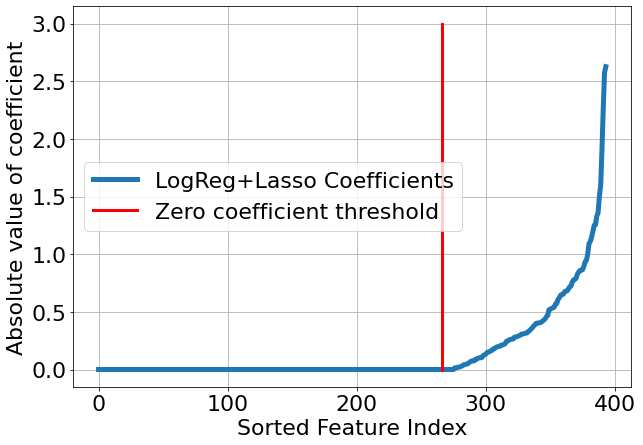

In [ ]:
matplotlib.rc('font', size=22)

plt.figure(figsize=(10,7))
plt.grid()
plt.plot(np.sort(np.abs(clf.coef_[0])), linewidth=5, 
    label = 'LogReg+Lasso Coefficients'
)
plt.xlabel('Sorted Feature Index')
plt.ylabel("Absolute value of coefficient")

plt.plot(
    [len(clf.coef_[0]) - 128,len(clf.coef_[0])-128],[0,3], color='red', linewidth=3
    , label='Zero coefficient threshold'
)
plt.legend()


In [ ]:
lasso_features = np.array(
    kept_features_after_pairwise_correlation
)[np.abs(clf.coef_[0])>0]
len(lasso_features)

128

###### test fit

In [ ]:
feature_selection={'status':False}
use_ray = False

measure_catboost = run_classification(
    pd.merge(
        labels_arm[['receptivity']],
        impute(agg_feature_percent_missing[
            #kept_features_after_pairwise_correlation
            lasso_features
        ])
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure_catboost.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 18.74it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,62.695,61.088,59.643,0.621,73.579,71.522,71.922,0.807


#### save seletected features 

In [ ]:
len(lasso_features)

128

In [ ]:
selected_features = list(
    set(map(lambda x: x[:x.find('|')], lasso_features))
)

pd.DataFrame({
    'features':selected_features
}).to_csv('selected_features.csv',index=False)


## Mine Association Rules
- uses RuleGenerateSet
- extract sliding features for (12 hours/20min) * 7 for each participant
- recode sliding features
- mine rules

#### extract sliding features


In [16]:
EXTRACTED_SLIDINGFEATURES = True

if not EXTRACTED_SLIDINGFEATURES:
    with on_ray(object_store_memory=2e10, ignore_reinit_error=True):    
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        sliding_features = recept_dataset.parallellize_extract_sliding(
                labels=labels_arm 
                , _sw_size_in_min = 20
                , selected_features=pd.read_csv(
                    'selected_features.csv'
                )['features'].values
            )
    sliding_features.to_csv('feature/arm/sliding_features.csv')
else:
    sliding_features = pd.read_csv(
        'feature/arm/sliding_features.csv'
        , dtype={'pid':'str'}
        , parse_dates=['timestamp']
    ).set_index(['pid','timestamp'])

sliding_features = impute(sliding_features)
sliding_features.isnull().sum().sort_values(ascending=False)     


appUsage_appCategory#ASC                     0
bandSkinTemperature_temperature#MINLAGVAL    0
accelerometer_Z#ASC                          0
accelerometer_Z#VAR                          0
accelerometer_Z#BEP                          0
                                            ..
ringer#SUP:RINGER_MODE_VIBRATE               0
ringer#SUP:RINGER_MODE_SILENT                0
ringer#ASC                                   0
ringer#ETP                                   0
battery_plugState#SUP:WIRELESS               0
Length: 105, dtype: int64

In [17]:
sliding_features.isnull().sum().sort_values(ascending=False)

appUsage_appCategory#ASC                     0
bandSkinTemperature_temperature#MINLAGVAL    0
accelerometer_Z#ASC                          0
accelerometer_Z#VAR                          0
accelerometer_Z#BEP                          0
                                            ..
ringer#SUP:RINGER_MODE_VIBRATE               0
ringer#SUP:RINGER_MODE_SILENT                0
ringer#ASC                                   0
ringer#ETP                                   0
battery_plugState#SUP:WIRELESS               0
Length: 105, dtype: int64

#### Recode

In [18]:
from copy import deepcopy        
def discretize_df(data, cols, pid):
    df = deepcopy(data)
    count1,count2, count3 = 0,0,0
    for col in cols:
        try:
            df[col] = pd.qcut(df[col], 3, labels=["l","m","h"])
            count3 += 1
        except:
            try:
                df[col] = pd.qcut(df[col], 2, labels=["l","h"])
                count2 += 1
            except:
                df[col] = pd.qcut(df[col], 1, labels=["m"])
                count1 += 1
    df.insert(0,'pid',pid)
    df = df.reset_index().set_index(['pid']+data.index.names)
    return df

In [19]:
df_recoded = [] 
for pid in tqdm(sliding_features.index.get_level_values('pid').unique()):    
    res = discretize_df(
        sliding_features.loc[pid]
        , sliding_features.columns.tolist()
        , pid
    )
    df_recoded.append(res)
df_recoded = pd.concat(df_recoded)
df_recoded = df_recoded.astype('str').fillna('missing').astype('category')
df_recoded.head()

100%|██████████| 36/36 [00:02<00:00, 12.44it/s]


appUsage_appCategory#ASC  \
pid  timestamp                                      
1501 2019-05-16 10:20:00                        l   
     2019-05-16 10:40:00                        l   
     2019-05-16 11:00:00                        l   
     2019-05-16 11:20:00                        l   
     2019-05-16 11:40:00                        l   

                         appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp                                                           
1501 2019-05-16 10:20:00                                             m   
     2019-05-16 10:40:00                                             l   
     2019-05-16 11:00:00                                             m   
     2019-05-16 11:20:00                                             m   
     2019-05-16 11:40:00                                             l   

                         appUsage_appCategory#SUP:Tools  \
pid  timestamp                                            
1501 2019-05-16 10:20:00                              l   
     2019-05-16 10:40:00                              l   
     2019-05-16 11:00:00                              l   
     2019-05-16 11:20:00                              l   
     2019-05-16 11:40:00                              l   

                         battery_temperature#MAX battery_temperature#BEP  \
pid  timestamp                                                             
1501 2019-05-16 10:20:00                       m                       m   
     2019-05-16 10:40:00                       l                       l   
     2019-05-16 11:00:00                       l                       h   
     2019-05-16 11:20:00                       l                       h   
     2019-05-16 11:40:00                       l                       h   

                         battery_temperature#VAR battery_temperature#MAXLAG  \
pid  timestamp                                                                
1501 2019-05-16 10:20:00                       h                          m   
     2019-05-16 10:40:00                       m                          m   
     2019-05-16 11:00:00                       l                          m   
     2019-05-16 11:20:00                       l                          m   
     2019-05-16 11:40:00                       l                          m   

                         battery_temperature#MAXLAGVAL  \
pid  timestamp                                           
1501 2019-05-16 10:20:00                             m   
     2019-05-16 10:40:00                             m   
     2019-05-16 11:00:00                             m   
     2019-05-16 11:20:00                             h   
     2019-05-16 11:40:00                             m   

                         battery_temperature#MINLAG  \
pid  timestamp                                        
1501 2019-05-16 10:20:00                          m   
     2019-05-16 10:40:00                          m   
     2019-05-16 11:00:00                          m   
     2019-05-16 11:20:00                          m   
     2019-05-16 11:40:00                          m   

                         battery_temperature#MINLAGVAL  ...  \
pid  timestamp                                          ...   
1501 2019-05-16 10:20:00                             h  ...   
     2019-05-16 10:40:00                             m  ...   
     2019-05-16 11:00:00                             m  ...   
     2019-05-16 11:20:00                             m  ...   
     2019-05-16 11:40:00                             m  ...   

                         bandDistance_speed#MAXLAGVAL bandDistance_speed#CID  \
pid  timestamp                                                                 
1501 2019-05-16 10:20:00                            m                      h   
     2019-05-16 10:40:00                            m                      h   
     2019-05-16 11:00:00                            m                      h  

### convert to transaction list

In [20]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import (
    apriori, fpmax,fpgrowth, association_rules
)

dataset = []
for i, r in df_recoded.iterrows():
    transaction = [f'{featurename}:{value}' 
                   for featurename, value in zip(r.index, r.values)]
    dataset.append(transaction)

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df


,accelerometer_X#CID:h,accelerometer_X#CID:l,accelerometer_X#CID:m,accelerometer_X#LTI:h,accelerometer_X#LTI:l,accelerometer_X#LTI:m,accelerometer_X#MINLAG:h,accelerometer_X#MINLAG:l,accelerometer_X#MINLAG:m,accelerometer_X#MINLAGVAL:h,...,wifi_numConnections#MAXLAGVAL:m,wifi_numConnections#MED:h,wifi_numConnections#MED:l,wifi_numConnections#MED:m,wifi_numConnections#MIN:h,wifi_numConnections#MIN:l,wifi_numConnections#MIN:m,wifi_numConnections#MINLAG:h,wifi_numConnections#MINLAG:l,wifi_numConnections#MINLAG:m
0,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
1,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
2,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
3,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
4,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,True,False,False,False,True,False,True,False,False,True,...,False,False,True,False,False,False,True,False,True,False
9068,False,False,True,False,True,False,True,False,False,False,...,True,False,True,False,False,True,False,False,True,False
9069,False,False,True,False,True,False,True,False,False,False,...,False,False,True,False,False,False,True,False,True,False
9070,False,False,True,True,False,False,False,True,False,False,...,True,False,True,False,False,True,False,False,True,False


#### mine frequent itemsets

In [21]:
frequent_itemsets = fpgrowth(
    df, min_support=0.3, use_colnames=True,
    max_len=5
)

frequent_itemsets

In [47]:
res = association_rules(
    frequent_itemsets
    , metric='confidence'
    ,  min_threshold=0.6
)

res

### consequent length=1 filter

In [37]:
res = res[res.apply(lambda x: len(x['consequents'])==1, axis=1)]
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(battery_status#SUP:FULL:m),(bandUV_indexLevel#SUP:NONE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
1,(bandUV_indexLevel#SUP:NONE:m),(battery_status#SUP:FULL:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
2,(battery_status#SUP:FULL:m),(appUsage_appCategory#SUP:Media/Entertainment:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
3,(appUsage_appCategory#SUP:Media/Entertainment:m),(battery_status#SUP:FULL:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
4,(bandUV_indexLevel#SUP:NONE:m),(appUsage_appCategory#SUP:Media/Entertainment:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
...,...,...,...,...,...,...,...,...,...
51911710,"(data_RX#MINLAG:m, battery_status#SUP:DISCHARG...",(activity_event#SUP:STILL:m),0.694,0.750,0.472,0.680,0.907,-0.049,0.781
51911711,"(data_RX#MINLAG:m, battery_status#SUP:DISCHARG...",(ringer#SUP:RINGER_MODE_VIBRATE:m),0.500,0.944,0.472,0.944,1.000,0.000,1.000
51911712,"(battery_status#SUP:DISCHARGING:m, ringer#SUP:...",(data_RX#MINLAG:m),0.611,0.833,0.472,0.773,0.927,-0.037,0.733
51911713,"(battery_status#SUP:DISCHARGING:m, ringer#SUP:...",(bandCalory_burned#MIN:m),0.500,0.972,0.472,0.944,0.971,-0.014,0.500


### filter rules for only top100 features

In [38]:
res = res[
    res.apply(
        lambda x: list(x['consequents'])[0][:-2] in top100_correlated_features
        , axis=1
    )
]
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
51,(connection_type#SUP:WIFI:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
53,(appUsage_appCategory#SUP:Media/Entertainment:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
54,(battery_status#SUP:FULL:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
57,(bandUV_indexLevel#SUP:NONE:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
60,(appUsage_appCategory#SUP:Media/Entertainment:...,(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
...,...,...,...,...,...,...,...,...,...
51911411,"(battery_status#SUP:DISCHARGING:m, ringer#SUP:...",(connection_type#SUP:MOBILE:m),0.500,1.000,0.500,1.000,1.000,0.000,inf
51911470,"(battery_status#SUP:DISCHARGING:m, ringer#SUP:...",(unlock#SUP:UNLOCK:m),0.500,1.000,0.500,1.000,1.000,0.000,inf
51911501,"(battery_status#SUP:DISCHARGING:m, ringer#SUP:...",(battery_plugState#SUP:WIRELESS:m),0.500,1.000,0.500,1.000,1.000,0.000,inf
51911563,"(battery_status#SUP:DISCHARGING:m, ringer#SUP:...",(activity_event#SUP:WALKING:m),0.500,0.972,0.500,1.000,1.029,0.014,inf


In [40]:
res.iloc[0].lift_log_scale_abs

AttributeError: 'Series' object has no attribute 'lift_log_scale_abs'

In [41]:


topk_rules = pd.concat([
    res.sort_values(['lift'],ascending=False)[:1000]
])
    
topk_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
18445734,"(screen#ETP:l, bandDistance_speed#MED:m, conne...",(screen#ASC:l),0.344,0.412,0.301,0.876,2.127,0.160,4.742
18445974,"(screen#ETP:l, bandDistance_speed#MED:m, conne...",(screen#ASC:l),0.344,0.412,0.301,0.876,2.127,0.160,4.742
18446814,"(screen#ETP:l, bandDistance_speed#MED:m, conne...",(screen#ASC:l),0.344,0.412,0.301,0.876,2.127,0.160,4.742
18446784,"(screen#ETP:l, bandDistance_speed#MED:m, conne...",(screen#ASC:l),0.344,0.412,0.301,0.876,2.127,0.160,4.742
18446725,"(screen#ETP:l, bandDistance_speed#MED:m, appUs...",(screen#ASC:l),0.344,0.412,0.301,0.876,2.127,0.160,4.742
...,...,...,...,...,...,...,...,...,...
48825181,"(bandDistance_speed#CID:m, battery_plugState#S...",(bandDistance_speed#BEP:m),0.500,0.583,0.500,1.000,1.714,0.208,inf
50125432,"(powerEvent#ETP:m, bandCalory_burned#MAX:l, ba...",(bandDistance_speed#BEP:m),0.443,0.583,0.443,1.000,1.714,0.185,inf
50125463,"(powerEvent#ETP:m, bandCalory_burned#MAX:l, ba...",(bandDistance_speed#BEP:m),0.443,0.583,0.443,1.000,1.714,0.185,inf
48825151,"(bandDistance_speed#CID:m, appUsage_appCategor...",(bandDistance_speed#BEP:m),0.500,0.583,0.500,1.000,1.714,0.208,inf


#### save rules

In [42]:
topk_rules["antecedents"] = topk_rules["antecedents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode")

topk_rules["consequents"] = topk_rules["consequents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode")

topk_rules.to_csv('top1000_rules.csv', index=False)

In [43]:
topk_rules_df = pd.read_csv('top1000_rules.csv')
topk_rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"screen#ETP:l, bandDistance_speed#MED:m, connec...",screen#ASC:l,0.344,0.412,0.301,0.876,2.127,0.160,4.742
1,"screen#ETP:l, bandDistance_speed#MED:m, connec...",screen#ASC:l,0.344,0.412,0.301,0.876,2.127,0.160,4.742
2,"screen#ETP:l, bandDistance_speed#MED:m, connec...",screen#ASC:l,0.344,0.412,0.301,0.876,2.127,0.160,4.742
3,"screen#ETP:l, bandDistance_speed#MED:m, connec...",screen#ASC:l,0.344,0.412,0.301,0.876,2.127,0.160,4.742
4,"screen#ETP:l, bandDistance_speed#MED:m, appUsa...",screen#ASC:l,0.344,0.412,0.301,0.876,2.127,0.160,4.742
...,...,...,...,...,...,...,...,...,...
995,"bandDistance_speed#CID:m, battery_plugState#SU...",bandDistance_speed#BEP:m,0.500,0.583,0.500,1.000,1.714,0.208,inf
996,"powerEvent#ETP:m, bandCalory_burned#MAX:l, ban...",bandDistance_speed#BEP:m,0.443,0.583,0.443,1.000,1.714,0.185,inf
997,"powerEvent#ETP:m, bandCalory_burned#MAX:l, bat...",bandDistance_speed#BEP:m,0.443,0.583,0.443,1.000,1.714,0.185,inf
998,"bandDistance_speed#CID:m, appUsage_appCategory...",bandDistance_speed#BEP:m,0.500,0.583,0.500,1.000,1.714,0.208,inf


# MLTrainEvalSet

In [44]:
selected_features = pd.read_csv('selected_features.csv')['features'].to_list()
len(selected_features),selected_features[:5]

(105,
 ['bandHeartRate_RRInterval#MINLAG',
  'wifi_numConnections#LTS',
  'ringer#ETP',
  'accelerometer_Y#LTS',
  'accelerometer_X#MINLAGVAL'])

### Full features

#### Extract 

In [30]:
ML_FULL_FEATURE_EXTRACTED=True
if not ML_FULL_FEATURE_EXTRACTED:
    ml_full_features = recept_dataset.parallellize_extract(
        labels=labels_ml, 
        w_size_in_min=80,
        selected_features=selected_features
        , use_ray =True
    )
    ml_full_features.to_csv(f'feature/ml/full_{window_size_in_min}MIN.csv')
else:
    ml_full_features = pd.read_csv(f'feature/ml/full_{window_size_in_min}MIN.csv'
        , dtype={'pid':'str'}
        , parse_dates=['timestamp']
    ).set_index(['pid','timestamp'])


In [31]:
ml_full_features.isnull().sum().sort_values(ascending=False)

battery_plugState#SUP:WIRELESS                   1491
connection_type#SUP:MOBILE                        857
ringer#SUP:RINGER_MODE_NORMAL                     619
ringer#SUP:RINGER_MODE_SILENT                     420
battery_status#SUP:FULL                           226
                                                 ... 
unlock#SUP:UNLOCK                                   0
screen#SUP:SCREEN_OFF                               0
appUsage_appCategory#SUP:Tools                      0
appUsage_appCategory#SUP:Social/Communication       0
activity_event#SUP:WALKING                          0
Length: 105, dtype: int64

#### Classification

In [32]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False
measure_list = []
for i, clfname in enumerate(classifier_names):
    measure = run_classification(
        pd.merge(
            labels_ml[['receptivity']],
            impute(
                impute_support_features(
                    normalize(
                        ml_full_features
                    )
                )
            )
            ,left_index=True, right_index=True
        ) 
        ,use_ray=use_ray, feature_selection=feature_selection,
        experiment_name=clfname
        , classifier_name=clfname
    )
    measure_list.append(measure)
ML_full_results = pd.concat(measure_list)
ML_full_results.groupby(['CV_TYPE','experiment']).mean()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values
5it [00:00, 17.60it/s]
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 

TEST_ACC  TEST_ACC_BAL  TEST_F1_score  TEST_AUC  \
CV_TYPE    experiment                                                    
LOGO_5fold adaboost      55.617        53.833         53.162     0.568   
           catboost      59.326        55.429         52.785     0.568   
           dt            55.227        53.301         52.822     0.533   
           gnb           55.644        55.504         54.491     0.586   
           gp            58.511        54.033         50.701     0.538   
           knn           54.669        53.004         51.921     0.541   
           lr            59.281        56.125         55.480     0.569   
           mlp           55.560        52.979         52.392     0.565   
           qda           57.113        55.008         54.359     0.572   
           rf            58.268        53.364         50.469     0.552   
           svm           59.674        56.088         54.593     0.575   

                       TRAIN_ACC  TRAIN_ACC_BAL  TRAIN_F1_score  TRAIN_AUC  
CV_TYPE    experiment                                                       
LOGO_5fold adaboost       76.723         75.113          75.496      0.852  
           catboost       99.273         99.131          99.249      1.000  
           dt            100.000        100.000         100.000      1.000  
           gnb            64.168         64.837          63.928      0.700  
           gp             90.936         89.237          90.276      0.982  
           knn            76.652         75.315          75.597      0.834  
           lr             71.438         68.800          69.146      0.767  
           mlp            85.592         84.716          84.883      0.930  
           qda            88.626         88.823          88.387      0.939  
           rf            100.000        100.000         100.000      1.000  
           svm            74.230         71.050          71.453      0.809


### Agg 

#### extract sub features
- extract sub features only for selected 


In [14]:
from itertools import product
nsub = 4
window_size_in_min = 80
ML_AGG_FEATURE_EXTRACTED = True

if not ML_AGG_FEATURE_EXTRACTED:
    with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=20):    
        print(f'{window_size_in_min}MIN at {nsub} subwindows')
        ml_sub_features = recept_dataset.parallellize_extract_sub(
            labels=labels_ml
            , w_size_in_min = 80
            ,num_sub=4
            , selected_features=selected_features
        )
        ml_sub_features.to_csv(
            f'feature/ml/subfeature_{window_size_in_min}MIN_{nsub}.csv'
        )
else:
    ml_sub_features = pd.read_csv(
        f'feature/ml/subfeature_{window_size_in_min}MIN_{nsub}.csv'
        , dtype={'pid':'str'}
        , parse_dates=['timestamp','sub_timestamp']
    ).set_index(['pid','timestamp','sub_timestamp'])
ml_sub_features

appUsage_appCategory#ASC  \
pid  timestamp           sub_timestamp                                   
3041 2019-05-01 10:30:08 2019-05-01 09:30:08                    23.000   
                         2019-05-01 09:50:08                    23.000   
                         2019-05-01 10:10:08                    19.000   
                         2019-05-01 10:30:08                    33.000   
     2019-05-01 11:26:31 2019-05-01 10:26:31                    33.000   
...                                                                ...   
1511 2019-05-22 19:47:55 2019-05-22 19:47:55                    37.000   
     2019-05-22 21:08:00 2019-05-22 20:08:00                     9.000   
                         2019-05-22 20:28:00                     0.000   
                         2019-05-22 20:48:00                     0.000   
                         2019-05-22 21:08:00                     3.000   

                                              appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp           sub_timestamp                                                        
3041 2019-05-01 10:30:08 2019-05-01 09:30:08                                        309.000   
                         2019-05-01 09:50:08                                        473.000   
                         2019-05-01 10:10:08                                        643.000   
                         2019-05-01 10:30:08                                        472.000   
     2019-05-01 11:26:31 2019-05-01 10:26:31                                        543.000   
...                                                                                     ...   
1511 2019-05-22 19:47:55 2019-05-22 19:47:55                                        362.000   
     2019-05-22 21:08:00 2019-05-22 20:08:00                                         70.000   
                         2019-05-22 20:28:00                                          0.000   
                         2019-05-22 20:48:00                                          0.000   
                         2019-05-22 21:08:00                                          0.000   

                                              appUsage_appCategory#SUP:Tools  \
pid  timestamp           sub_timestamp                                         
3041 2019-05-01 10:30:08 2019-05-01 09:30:08                          64.000   
                         2019-05-01 09:50:08                         354.000   
                         2019-05-01 10:10:08                         508.000   
                         2019-05-01 10:30:08                         396.000   
     2019-05-01 11:26:31 2019-05-01 10:26:31                         398.000   
...                                                                      ...   
1511 2019-05-22 19:47:55 2019-05-22 19:47:55                         217.000   
     2019-05-22 21:08:00 2019-05-22 20:08:00                         438.000   
                         2019-05-22 20:28:00                           0.000   
                         2019-05-22 20:48:00                           0.000   
                         2019-05-22 21:08:00                          18.000   

                                              battery_temperature#MAX  \
pid  timestamp           sub_timestamp                                  
3041 2019-05-01 10:30:08 2019-05-01 09:30:08                   26.205   
                         2019-05-01 09:50:08                   26.157   
                         2019-05-01 10:10:08                   27.900   
                         2019-05-01 10:30:08                   29.100   
     2019-05-01 11:26:31 2019-05-01 10:26:31                   28.742   
...                                                               ...   
1511 2019-05-22 19:47:55 2019-05-22 19:47:55                   31.270   
     2019-05-22 21:08:00 2019-05-22 20:08:00                   32.200   
                         2019-05-22 20:28:00                   29.638   
   

In [51]:
ml_sub_features.isnull().sum().sort_values(ascending=False)

ringer#ETP                                       869
ringer#ASC                                       869
powerEvent#ETP                                   258
activity_event#ETP                               131
location_distance#MINLAG                          90
                                                ... 
screen#SUP:SCREEN_OFF                              0
activity_event#SUP:WALKING                         0
appUsage_appCategory#SUP:Social/Communication      0
bandUV_indexLevel#SUP:NONE                         0
battery_plugState#SUP:WIRELESS                     0
Length: 105, dtype: int64

#### extract aggregated features
- sub feature prep 
    - impute support features before agg feature compute
- agg features should be extracted from sub features
    - normalize
    - impute

In [52]:
ml_agg_feature = impute_support_features(ml_sub_features).groupby(
    ['pid','timestamp']
).agg(['mean','std'])
ml_agg_feature.columns = ml_agg_feature.columns.map('|'.join).str.strip('|')
ml_agg_feature.to_csv(
    f'feature/ml/agg_feature_{window_size_in_min}MIN_{nsub}.csv'
)

#### Classification performance

In [56]:
feature_selection={'status':False}
use_ray = False

ML_AGG_RESULT = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        impute(
            normalize(ml_agg_feature)
        )
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='ml-lr'
    , classifier_name='lr'
)
ML_AGG_RESULT.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 14.70it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,ml-lr,59.415,56.333,55.640,0.591,74.416,72.213,72.671,0.807


### CFF
- sub features
    - impute
    - recode
- compute cff

#### recode sub featyures

In [18]:
ml_sub_features_preprocessed = impute(ml_sub_features)
ml_sub_recoded = [] 
for pid in tqdm(
    ml_sub_features_preprocessed.index.get_level_values('pid').unique()
):    
    res = discretize_df(ml_sub_features_preprocessed.loc[pid],
                        ml_sub_features_preprocessed.columns.tolist(), pid)
    ml_sub_recoded.append(res)
ml_sub_recoded = pd.concat(ml_sub_recoded)
ml_sub_recoded = ml_sub_recoded.astype('str').fillna(
    'missing'
).astype('category')
ml_sub_recoded.head()

100%|██████████| 37/37 [00:02<00:00, 12.62it/s]


appUsage_appCategory#ASC  \
pid  timestamp           sub_timestamp                                  
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                        h   
                         2019-05-16 10:39:31                        h   
                         2019-05-16 10:59:31                        h   
                         2019-05-16 11:19:31                        h   
     2019-05-16 12:49:26 2019-05-16 11:49:26                        m   

                                             appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp           sub_timestamp                                                       
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                                             h   
                         2019-05-16 10:39:31                                             h   
                         2019-05-16 10:59:31                                             h   
                         2019-05-16 11:19:31                                             h   
     2019-05-16 12:49:26 2019-05-16 11:49:26                                             m   

                                             appUsage_appCategory#SUP:Tools  \
pid  timestamp           sub_timestamp                                        
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                              h   
                         2019-05-16 10:39:31                              h   
                         2019-05-16 10:59:31                              m   
                         2019-05-16 11:19:31                              m   
     2019-05-16 12:49:26 2019-05-16 11:49:26                              h   

                                             battery_temperature#MAX  \
pid  timestamp           sub_timestamp                                 
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                       m   
                         2019-05-16 10:39:31                       m   
                         2019-05-16 10:59:31                       m   
                         2019-05-16 11:19:31                       l   
     2019-05-16 12:49:26 2019-05-16 11:49:26                       m   

                                             battery_temperature#BEP  \
pid  timestamp           sub_timestamp                                 
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                       h   
                         2019-05-16 10:39:31                       h   
                         2019-05-16 10:59:31                       m   
                         2019-05-16 11:19:31                       m   
     2019-05-16 12:49:26 2019-05-16 11:49:26                       m   

                                             battery_temperature#VAR  \
pid  timestamp           sub_timestamp                                 
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                       m   
                         2019-05-16 10:39:31                       m   
                         2019-05-16 10:59:31                       l   
                         2019-05-16 11:19:31                       l   
     2019-05-16 12:49:26 2019-05-16 11:49:26                       m   

                                             battery_temperature#MAXLAG  \
pid  timestamp           sub_timestamp                                    
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                          m   
                         2019-05-16 10:39:31                          m   
                         2019-05-16 10:59:31                          m   
                         2019-05-16 11:19:31                          m   
     2019-05-16 12:49:26 2019-05-16 11:49:26                          m   

                                             battery_temperature#MAXLAGVAL  \
pid  timestamp           sub_timestamp                                       
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                             h   
                         2019-05-16 10:39:31 

#### extract 

- for each rule
  - select the df that satisfy the context
     - extract Y from contextually filtered subfeatures and add to features


In [19]:
rules = pd.read_csv(
    'top1000_rules.csv'
    , usecols=['antecedents','consequents']
    , dtype={'lift':float}
)

rules

,antecedents,consequents
0,"screen#ETP:l, bandDistance_speed#MED:m, connec...",screen#ASC:l
1,"screen#ETP:l, bandDistance_speed#MED:m, connec...",screen#ASC:l
2,"screen#ETP:l, bandDistance_speed#MED:m, connec...",screen#ASC:l
3,"screen#ETP:l, bandDistance_speed#MED:m, connec...",screen#ASC:l
4,"screen#ETP:l, bandDistance_speed#MED:m, appUsa...",screen#ASC:l
...,...,...
995,"bandDistance_speed#CID:m, battery_plugState#SU...",bandDistance_speed#BEP:m
996,"powerEvent#ETP:m, bandCalory_burned#MAX:l, ban...",bandDistance_speed#BEP:m
997,"powerEvent#ETP:m, bandCalory_burned#MAX:l, bat...",bandDistance_speed#BEP:m
998,"bandDistance_speed#CID:m, appUsage_appCategory...",bandDistance_speed#BEP:m


In [20]:
rules.consequents.unique()

array(['screen#ASC:l', 'screen#ETP:l', 'bandDistance_speed#BEP:m'],
      dtype=object)

In [21]:

features = {}
for i,rule in tqdm(rules.iterrows()):
    X, Y = rule['antecedents'], rule['consequents']
    y_name, y_val = Y[:-2], Y[-1]
    
    for x in X.split(', '):
        x_name, x_val = x[:-2], x[-1]
        
        M = ml_sub_recoded[x_name]==x_val
        selected_context = ml_sub_features[M][y_name]
        f = selected_context.groupby([
                'pid','timestamp'
        ]).agg(['mean','std'])
        features[f'mean-{y_name}_context={x_name}'] = f['mean']
        features[f'std-{y_name}_context={x_name}'] = f['std']
featuresCFF = pd.DataFrame(features )
featuresCFF.isnull().sum().sort_values(ascending=False)

0it [00:00, ?it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
1000it [00:52, 19.14it/s]


std-screen#ASC_context=screen#ETP                                       1058
std-screen#ETP_context=screen#ASC                                        974
std-bandDistance_speed#BEP_context=bandDistance_speed#MAXLAGVAL          743
std-bandDistance_speed#BEP_context=activity_event#SUP:STILL              701
mean-bandDistance_speed#BEP_context=activity_event#SUP:STILL             699
                                                                        ... 
mean-bandDistance_speed#BEP_context=unlock#SUP:UNLOCK                      3
mean-bandDistance_speed#BEP_context=appUsage_appCategory#SUP:Finance       3
mean-bandDistance_speed#BEP_context=battery_plugState#SUP:WIRELESS         3
mean-bandDistance_speed#BEP_context=connection_status#SUP:False            3
mean-bandDistance_speed#BEP_context=bandDistance_speed#MED                 3
Length: 126, dtype: int64

#### Classifier Performance

In [22]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False

measure = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        impute(
                normalize(
                    featuresCFF
                )
        )
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values
5it [00:00, 27.14it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,51.636,50.235,47.558,0.561,69.652,67.997,68.073,0.755


In [23]:
featuresCFF.corr()

,mean-screen#ASC_context=screen#ETP,std-screen#ASC_context=screen#ETP,mean-screen#ASC_context=bandDistance_speed#MED,std-screen#ASC_context=bandDistance_speed#MED,mean-screen#ASC_context=connection_status#SUP:False,std-screen#ASC_context=connection_status#SUP:False,mean-screen#ASC_context=ringer#SUP:RINGER_MODE_NORMAL,std-screen#ASC_context=ringer#SUP:RINGER_MODE_NORMAL,mean-screen#ASC_context=battery_plugState#SUP:WIRELESS,std-screen#ASC_context=battery_plugState#SUP:WIRELESS,...,mean-bandDistance_speed#BEP_context=battery_temperature#MINLAG,std-bandDistance_speed#BEP_context=battery_temperature#MINLAG,mean-bandDistance_speed#BEP_context=bandDistance_pace#MIN,std-bandDistance_speed#BEP_context=bandDistance_pace#MIN,mean-bandDistance_speed#BEP_context=ringer#ETP,std-bandDistance_speed#BEP_context=ringer#ETP,mean-bandDistance_speed#BEP_context=battery_status#SUP:DISCHARGING,std-bandDistance_speed#BEP_context=battery_status#SUP:DISCHARGING,mean-bandDistance_speed#BEP_context=location_distance#MINLAG,std-bandDistance_speed#BEP_context=location_distance#MINLAG
mean-screen#ASC_context=screen#ETP,1.000,0.678,0.547,0.212,0.547,0.212,0.547,0.212,0.547,0.212,...,0.089,0.090,0.042,0.069,0.045,0.076,0.049,0.078,0.089,0.090
std-screen#ASC_context=screen#ETP,0.678,1.000,0.521,0.395,0.521,0.395,0.521,0.395,0.521,0.395,...,0.057,0.152,-0.010,0.120,-0.015,0.119,-0.005,0.127,0.057,0.152
mean-screen#ASC_context=bandDistance_speed#MED,0.547,0.521,1.000,0.760,1.000,0.760,1.000,0.760,1.000,0.760,...,0.159,0.212,0.111,0.192,0.109,0.194,0.121,0.202,0.159,0.212
std-screen#ASC_context=bandDistance_speed#MED,0.212,0.395,0.760,1.000,0.760,1.000,0.760,1.000,0.760,1.000,...,0.156,0.228,0.107,0.213,0.109,0.217,0.117,0.222,0.156,0.228
mean-screen#ASC_context=connection_status#SUP:False,0.547,0.521,1.000,0.760,1.000,0.760,1.000,0.760,1.000,0.760,...,0.159,0.212,0.111,0.192,0.109,0.194,0.121,0.202,0.159,0.212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
std-bandDistance_speed#BEP_context=ringer#ETP,0.076,0.119,0.194,0.217,0.194,0.217,0.194,0.217,0.194,0.217,...,0.458,1.000,0.425,1.000,0.425,1.000,0.428,1.000,0.458,1.000
mean-bandDistance_speed#BEP_context=battery_status#SUP:DISCHARGING,0.049,-0.005,0.121,0.117,0.121,0.117,0.121,0.117,0.121,0.117,...,1.000,0.470,1.000,0.435,1.000,0.428,1.000,0.435,1.000,0.470
std-bandDistance_speed#BEP_context=battery_status#SUP:DISCHARGING,0.078,0.127,0.202,0.222,0.202,0.222,0.202,0.222,0.202,0.222,...,0.470,1.000,0.435,1.000,0.428,1.000,0.435,1.000,0.470,1.000
mean-bandDistance_speed#BEP_context=location_distance#MINLAG,0.089,0.057,0.159,0.156,0.159,0.156,0.159,0.156,0.159,0.156,...,1.000,0.465,1.000,0.465,1.000,0.458,1.000,0.470,1.000,0.465


In [37]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False

kept_features = remove_pairwise_corr(featuresCFF.corr(),.9999)
print("kept_features",len(kept_features))

measure = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        impute(
                normalize(
                    featuresCFF[kept_features]
                )
        )
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

kept_features 18


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values
5it [00:00, 47.27it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,58.355,53.122,49.556,0.594,62.871,58.263,56.818,0.674


### Combining

In [33]:
data = pd.merge(
    impute(
        impute_support_features(
            normalize(ml_full_features)
        )
    )
    , 
    impute(
        normalize(featuresCFF[kept_features])        
    )
    , left_index=True
    , right_index=True 
)
# data = pd.merge(data,ml_agg_feature, left_index=True, right_index=True )
#data = pd.merge(labels_ml[['receptivity']], data, left_index=True, right_index=True )
data.shape

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values


(1754, 122)

In [86]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False

measure = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        data
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 14.02it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,61.216,57.209,56.987,0.599,73.521,71.384,71.779,0.802


In [36]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False
measure_list = []
for i,clfname in enumerate(classifier_names):
    print(f'running {clfname} {i}/{len(classifier_names)}')
    measure = run_classification(
        pd.merge(
            labels_ml[['receptivity']],
            data
            ,left_index=True, right_index=True
        ) 
        ,use_ray=use_ray, feature_selection=feature_selection,
        experiment_name=clfname
        , classifier_name=clfname
    )
    measure_list.append(measure)
combined_measure = pd.concat(measure_list)
combined_measure.groupby(['CV_TYPE','experiment']).mean()

2it [00:00, 19.15it/s]

running lr 0/11


5it [00:00, 17.04it/s]
2it [00:00, 19.77it/s]

running knn 1/11


5it [00:00, 19.87it/s]
0it [00:00, ?it/s]

running svm 2/11


5it [00:01,  2.84it/s]
0it [00:00, ?it/s]

running gp 3/11


5it [00:07,  1.52s/it]
2it [00:00, 13.73it/s]

running dt 4/11


5it [00:00, 14.36it/s]
0it [00:00, ?it/s]

running rf 5/11


5it [00:02,  2.41it/s]
0it [00:00, ?it/s]

running mlp 6/11


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
1it [00:01,  1.01s/it]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
2it [00:01,  1.01it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
3it [00:03,  1.04s/it]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum 

running adaboost 7/11


5it [00:01,  2.56it/s]
5it [00:00, 114.25it/s]
0it [00:00, ?it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
5it [00:00, 41.74it/s]
0it [00:00, ?it/s]

running gnb 8/11
running qda 9/11
running catboost 10/11


5it [00:08,  1.72s/it]


TEST_ACC  TEST_ACC_BAL  TEST_F1_score  TEST_AUC  \
CV_TYPE    experiment                                                    
LOGO_5fold adaboost      60.619        57.667         57.310     0.605   
           catboost      60.690        56.577         55.630     0.601   
           dt            53.356        50.896         50.541     0.509   
           gnb           59.925        58.069         56.817     0.607   
           gp            56.951        53.571         52.560     0.546   
           knn           55.373        52.631         52.399     0.535   
           lr            61.271        57.281         57.096     0.602   
           mlp           60.202        56.439         56.285     0.603   
           qda           59.409        54.296         51.764     0.576   
           rf            60.638        55.805         54.388     0.601   
           svm           58.760        53.887         52.903     0.578   

                       TRAIN_ACC  TRAIN_ACC_BAL  TRAIN_F1_score  TRAIN_AUC  
CV_TYPE    experiment                                                       
LOGO_5fold adaboost       78.336         76.845          77.231      0.871  
           catboost       99.486         99.392          99.471      1.000  
           dt            100.000        100.000         100.000      1.000  
           gnb            65.097         66.381          64.953      0.729  
           gp             96.136         95.601          95.971      0.990  
           knn            77.780         76.599          76.839      0.852  
           lr             73.818         71.722          72.123      0.804  
           mlp            90.196         89.627          89.813      0.963  
           qda            86.648         85.401          85.144      0.952  
           rf            100.000        100.000         100.000      1.000  
           svm            76.851         74.542          75.098      0.840

In [80]:
data.corr()
# import pandas
# pd.set_option("display.precision", 2)
data.corr().iloc[:10,:10].style.background_gradient(cmap='coolwarm')

,appUsage_appCategory#ASC,appUsage_appCategory#SUP:Finance,appUsage_appCategory#SUP:Social/Communication,appUsage_appCategory#SUP:Tools,battery_temperature#MAX,battery_temperature#BEP,battery_temperature#VAR,battery_temperature#MAXLAG,battery_temperature#MAXLAGVAL,battery_temperature#MINLAG
appUsage_appCategory#ASC,1.00,0.11,0.33,0.22,0.24,0.33,0.15,0.01,0.29,0.11
appUsage_appCategory#SUP:Finance,0.11,1.00,0.11,0.01,0.10,0.05,0.07,0.03,0.05,0.02
appUsage_appCategory#SUP:Social/Communication,0.33,0.11,1.00,0.03,0.19,0.21,0.09,0.02,0.18,0.10
appUsage_appCategory#SUP:Tools,0.22,0.01,0.03,1.00,0.28,0.19,0.11,0.01,0.18,0.11
battery_temperature#MAX,0.24,0.10,0.19,0.28,1.00,0.24,0.44,0.01,0.25,0.21
battery_temperature#BEP,0.33,0.05,0.21,0.19,0.24,1.00,0.13,0.10,0.88,0.59
battery_temperature#VAR,0.15,0.07,0.09,0.11,0.44,0.13,1.00,0.11,0.17,0.27
battery_temperature#MAXLAG,0.01,0.03,0.02,0.01,0.01,0.10,0.11,1.00,0.08,0.14
battery_temperature#MAXLAGVAL,0.29,0.05,0.18,0.18,0.25,0.88,0.17,0.08,1.00,0.69
battery_temperature#MINLAG,0.11,0.02,0.10,0.11,0.21,0.59,0.27,0.14,0.69,1.00


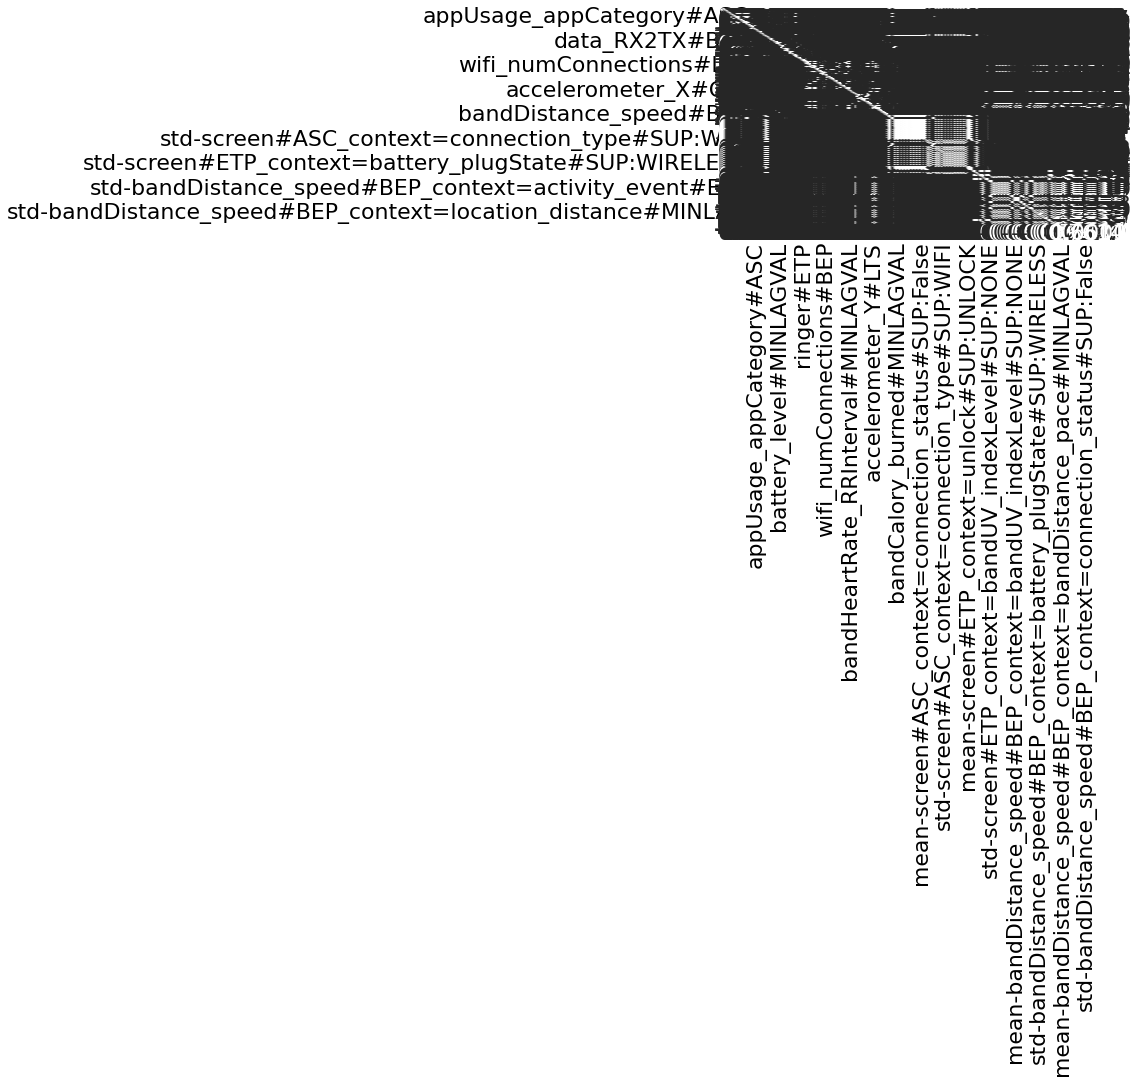

In [82]:
import seaborn as sns
fig, ax = plt.subplots()

sns.heatmap(data.corr(), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

In [98]:
print(data.corr().shape)

keept_features = remove_pairwise_corr(data.corr(), .6)
print(len(keept_features))

(213, 213)
82


In [101]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False
keept_features = remove_pairwise_corr(data.corr(), .65)

measure = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        data[keept_features]
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray
    , feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 23.14it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,60.217,56.438,56.270,0.582,72.860,70.670,71.052,0.784


In [111]:
measure_list = []
for i,clfname in enumerate(classifier_names):
    print(f'{i}/{len(classifier_names)}:{clfname}')
    measure = run_classification(
        pd.merge(
            labels_ml[['receptivity']],
            data[keept_features]
            ,left_index=True, right_index=True
        ) 
        ,use_ray=use_ray
        , feature_selection=feature_selection,
        experiment_name=clfname
        , classifier_name=clfname
    )
    measure_list.append(measure)

measure.groupby(['CV_TYPE','experiment']).mean()

0/14:lr


5it [00:00, 17.23it/s]


1/14:lr_lasso_C=0.1


5it [00:00, 22.28it/s]
5it [00:00, 45.65it/s]


2/14:lr_lasso_C=0.01
3/14:lr_lasso_C=0.1_maxiter=1000


5it [00:00, 21.44it/s]


4/14:knn


5it [00:00, 23.79it/s]


5/14:svm


5it [00:01,  3.18it/s]


6/14:gp


5it [00:07,  1.54s/it]


7/14:dt


5it [00:00, 18.52it/s]


8/14:rf


5it [00:01,  2.78it/s]


9/14:mlp


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet

10/14:adaboost


5it [00:01,  3.27it/s]
5it [00:00, 120.75it/s]
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
5it [00:00, 46.60it/s]


11/14:gnb
12/14:qda
13/14:catboost


5it [00:06,  1.22s/it]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,catboost,61.160,56.574,55.464,0.589,99.244,99.116,99.218,1.000


In [112]:
pd.concat(measure_list).groupby(['CV_TYPE','experiment']).mean()

TEST_ACC  TEST_ACC_BAL  TEST_F1_score  \
CV_TYPE    experiment                                                           
LOGO_5fold adaboost                       61.492        58.549         58.346   
           catboost                       61.160        56.574         55.464   
           dt                             53.503        51.268         50.959   
           gnb                            60.519        57.957         57.814   
           gp                             59.829        55.773         54.807   
           knn                            56.227        54.758         54.333   
           lr                             60.217        56.438         56.270   
           lr_lasso_C=0.01                58.471        50.000         36.739   
           lr_lasso_C=0.1                 57.984        52.592         49.764   
           lr_lasso_C=0.1_maxiter=1000    57.984        52.592         49.764   
           mlp                            60.559        56.529         56.150   
           qda                            61.220        57.112         56.702   
           rf                             61.237        56.344         54.614   
           svm                            59.337        55.247         54.279   

                                        TEST_AUC  TRAIN_ACC  TRAIN_ACC_BAL  \
CV_TYPE    experiment                                                        
LOGO_5fold adaboost                        0.606     77.750         76.232   
           catboost                        0.589     99.244         99.116   
           dt                              0.513    100.000        100.000   
           gnb                             0.593     67.049         67.251   
           gp                              0.580     92.402         91.290   
           knn                             0.564     77.564         76.437   
           lr                              0.582     72.860         70.670   
           lr_lasso_C=0.01                 0.500     58.440         50.000   
           lr_lasso_C=0.1                  0.534     66.006         61.373   
           lr_lasso_C=0.1_maxiter=1000     0.534     66.006         61.373   
           mlp                             0.589     87.153         86.260   
           qda                             0.595     86.101         86.077   
           rf                              0.587    100.000        100.000   
           svm                             0.590     76.423         74.085   

                                        TRAIN_F1_score  TRAIN_AUC  
CV_TYPE    experiment                                              
LOGO_5fold adaboost                             76.612      0.863  
           catboost                             99.218      1.000  
           dt                                  100.000      1.000  
           gnb                                  66.643      0.721  
           gp                                   91.989      0.979  
           knn                                  76.648      0.858  
           lr                                   71.052      0.784  
           lr_lasso_C=0.01                      36.875      0.500  
           lr_lasso_C=0.1                       60.136      0.707  
           lr_lasso_C=0.1_maxiter=1000          60.136      0.707  
           mlp                                  86.527      0.946  
           qda                                  85.775      0.919  
           rf                                  100.000      1.000  
           svm                                  74.553      0.831